In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#TensorFlow Hub MobileNet

with the last layer (the classification layer)
basically all of the model

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
img_res = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL,input_shape=(img_res,img_res,3))
])

In [0]:
import numpy as np
import PIL.Image as Image

In [4]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


16384/10484 [==============================================] - 0s 0us/step


In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80,20))
splits,info = tfds.load('cats_vs_dogs',with_info=True,split=splits,as_supervised=True)
train_data,val_data = splits
num_data = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [0]:
def format_img(img,label):
  img = tf.image.resize(img,(img_res,img_res))/255.0
  return img,label

batch_size = 32
train_batches = train_data.shuffle(num_data//4).map(format_img).batch(batch_size).prefetch(1)
val_batches = val_data.map(format_img).batch(batch_size).prefetch(1)

In [0]:
img_batch,label_batch = next(iter(train_batches.take(1)))
img_batch = img_batch.numpy()
label_batch = label_batch.numpy()
result_batch = model.predict(img_batch)
predicted_class_name = imagenet_labels[np.argmax(result_batch,axis=-1)]

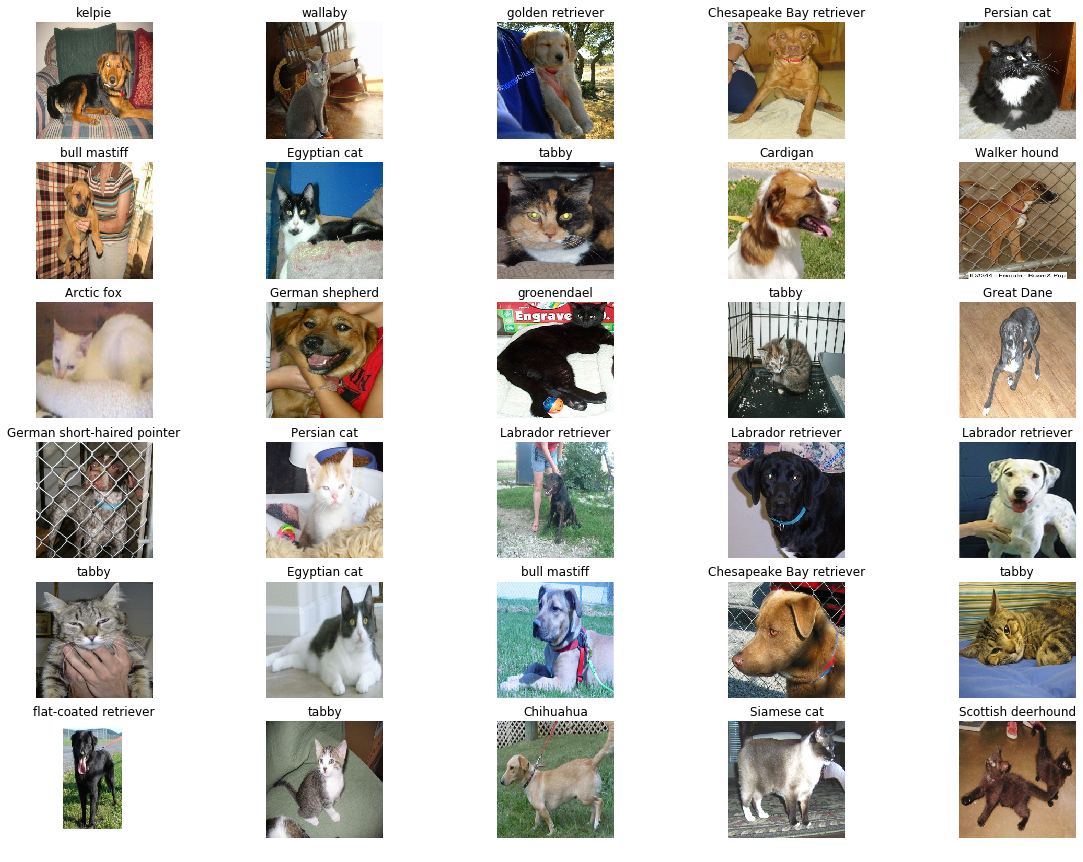

In [10]:
plt.figure(figsize=(20,15))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(img_batch[n])
  plt.axis('off')
  plt.title(predicted_class_name[n])

#Do simple transfer learning with TensorFlow Hub

without the last layer (classification layer)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
features = hub.KerasLayer(URL,input_shape=(img_res,img_res,3))

In [12]:
feature_batch = features(img_batch)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
features.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [14]:
model = tf.keras.Sequential([
    
    features,
    tf.keras.layers.Dense(2,activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

epochs = 2
trained = model.fit(train_batches,epochs=epochs,
                   validation_data=val_batches)

In [0]:
train_acc = trained.history['acc']
val_acc = trained.history['val_acc']

train_loss = trained.history['loss']
val_loss = trained.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,train_acc,label='train accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_loss,label='train loss')
plt.plot(epochs_range,val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()

#predictions

In [0]:
class_names = np.array(info.features['label'].names)

predicted_class = model.predict(img_batch)
predicted_class = tf.squeeze(predicted_class).numpy()

predicted_class_ids = np.argmax(predicted_class,axis=-1)
predicted_class_name = class_names[np.argmax(predicted_class,axis=-1)]

In [0]:
print(class_names)
print(predicted_class_name)
print(predicted_class_ids)

In [0]:
plt.figure(figsize=(12,12))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(img_batch[n])
  color = 'blue' if predicted_class_ids[n] == label_batch[n] else 'red'
  plt.axis('off')
  plt.title(predicted_class_name[n].title(),color=color)